In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


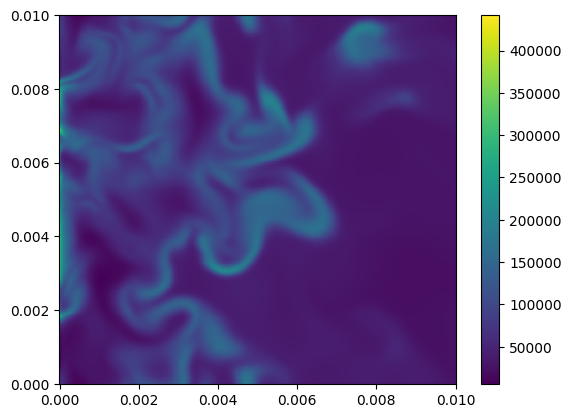

In [ ]:
# library
import numpy as np
import matplotlib.pyplot as plt

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01 #[m]
dx, dy = lx/(nx-1), ly/(ny-1)
x = np.arange(0,lx+dx,dx)
y = np.arange(0,ly+dy,dy)

# flame related constants
TU = 1500.000 #K
TB = 1623.47 #K

# data load
data_path = '/content/drive/MyDrive/TAAS24-25/mission1/wtemp-slice-B1-0000080000.raw'
data = np.fromfile( data_path, count=-1, dtype=np.float64).reshape(nx,ny)

# data plot
plt.pcolor(x, y, np.moveaxis(data, (0,1), (1,0)))
plt.colorbar()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


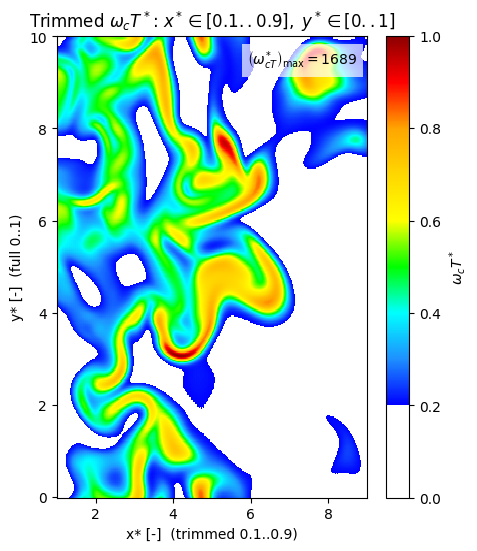

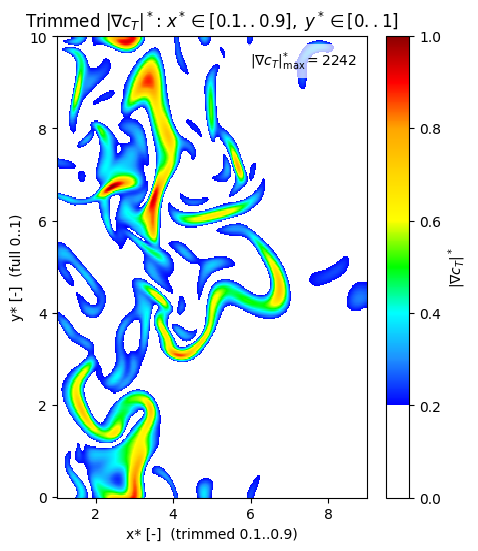

1688.5234204489282 3582.3483319376846
2242.463031980687 4104.347719341682


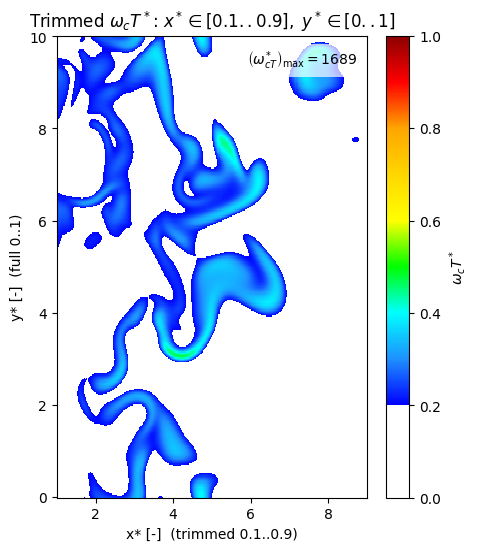

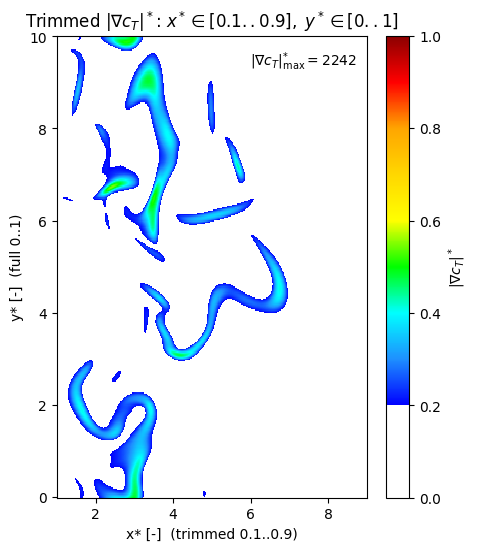

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Library imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

###############################################################################
# Spatial constants
###############################################################################
nx, ny = 384, 384
lx, ly = 0.01, 0.01  # [m]
dx, dy = lx / (nx - 1), ly / (ny - 1)

# Generate full coordinate arrays (in physical units)
x_full = np.arange(0, lx + dx, dx)  # might be length=385 if including lx+dx
y_full = np.arange(0, ly + dy, dy)

# Alternatively, if your raw data is strictly 384x384 from 0..lx:
# x_full = np.linspace(0, lx, nx)
# y_full = np.linspace(0, ly, ny)

###############################################################################
# Flame-related constants
###############################################################################
TU = 1500.000  # [K]
TB = 1623.47   # [K]

###############################################################################
# Load Q/cp field for ω_cT
###############################################################################
data_path_wct = '/content/drive/MyDrive/TAAS24-25/mission1/wtemp-slice-B1-0000080000.raw'
Q_cp = np.fromfile(data_path_wct, dtype=np.float64).reshape(nx, ny)

# Compute ω_cT (no trimming yet)
omega_cT_full = Q_cp / (TB - TU)

omega_max_cracked = np.max(omega_cT_full)

###############################################################################
# Load temperature gradient field for ∇cT
###############################################################################
data_path_gradT = '/content/drive/MyDrive/TAAS24-25/mission1/nablatemp-slice-B1-0000080000.raw'
nabla_T = np.fromfile(data_path_gradT, dtype=np.float64).reshape(nx, ny)

# Compute |∇cT|
grad_cT_full = nabla_T / (TB - TU)

grad_cT_cracked = np.max(grad_cT_full)

###############################################################################
# 1) Normalize coordinates: x* = x / max(x_full), y* = y / max(y_full)
#    Then find indices where 0.1 <= x^* <= 0.9
#    Keep entire y range [0..1].
###############################################################################
x_star = x_full / np.max(x_full)  # range [0..1]
y_star = y_full / np.max(y_full)  # range [0..1]

# Indices that satisfy 0.1 <= x^* <= 0.9
x_indices = np.where((x_star >= 0.1) & (x_star <= 0.9))[0]

# Keep all y indices (so y goes 0..1)
y_indices = np.arange(len(y_full))

# Slice coordinates
x_trim = x_full[x_indices] * 1000
y_trim = y_full * 1000  # unchanged

# Slice data arrays
omega_cT = omega_cT_full[np.ix_(x_indices, y_indices)]
grad_cT  = grad_cT_full[np.ix_(x_indices, y_indices)]

###############################################################################
# 2) Compute maxima on the trimmed domain, then normalize to [0..1]
###############################################################################
max_omega_cT = np.max(omega_cT)
omega_cT_star = omega_cT / max_omega_cT #omega_max_cracked

max_grad_cT = np.max(grad_cT)
grad_cT_star = grad_cT / max_grad_cT #grad_cT_cracked

###############################################################################
# 3) Create a piecewise colormap
#    - 0..0.2 => white
#    - 0.2..1 => multi-color from blue to darkred
###############################################################################
cmap_list = [
    (0.0,     "white"),
    (0.2,     "white"),
    (0.2,     "blue"),
    (0.3,     "dodgerblue"),
    (0.4,     "cyan"),
    (0.5,     "lime"),
    (0.6,     "yellow"),
    (0.7,     "gold"),
    (0.8,     "orange"),
    (0.9,     "red"),
    (1.0,     "darkred"),
]
cmap_custom = mcolors.LinearSegmentedColormap.from_list("whiteToRed", cmap_list, N=512)

###############################################################################
# 4) Plot the trimmed ω_cT*
###############################################################################
plt.figure(figsize=(5, 6))

# For the x-axis, we use x_trim / max(x_trim) => [0.1..0.9]
# For the y-axis, we use y_trim / max(y_trim) => [0..1]
plt.pcolor(
    x_trim,
    y_trim,
    np.moveaxis(omega_cT_star, (0, 1), (1, 0)),
    cmap=cmap_custom,
    shading="auto",
    vmin=0.0,
    vmax=1.0
)
plt.colorbar(label=r"$\omega_c T^*$")

plt.xlabel("x* [-]  (trimmed 0.1..0.9)")
plt.ylabel("y* [-]  (full 0..1)")
plt.title(r"Trimmed $\omega_c T^*$: $x^*\in[0.1..0.9], \; y^*\in[0..1]$")

# Annotate max
plt.text(
    0.97, 0.97,
    rf"$\left(\omega_{{cT}}^{{*}}\right)_{{\max}} = {max_omega_cT:.4g}$",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)
plt.show()

###############################################################################
# 5) Plot the trimmed |∇cT|*
###############################################################################
plt.figure(figsize=(5, 6))

plt.pcolor(
    x_trim,
    y_trim,
    np.moveaxis(grad_cT_star, (0, 1), (1, 0)),
    cmap=cmap_custom,
    shading="auto",
    vmin=0.0,
    vmax=1.0
)
plt.colorbar(label=r"$|\nabla c_T|^*$")

plt.xlabel("x* [-]  (trimmed 0.1..0.9)")
plt.ylabel("y* [-]  (full 0..1)")
plt.title(r"Trimmed $|\nabla c_T|^*$: $x^*\in[0.1..0.9], \; y^*\in[0..1]$")

# Annotate max
plt.text(
    0.97, 0.97,
    rf"$|\nabla c_T|^{{*}}_{{\max}} = {max_grad_cT:.4g}$",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)
plt.show()

print(max_omega_cT, omega_max_cracked)
print(max_grad_cT, grad_cT_cracked)


omega_cT_star_global = omega_cT / omega_max_cracked
grad_cT_star_global = grad_cT / grad_cT_cracked

###############################################################################
# 6) Plot the trimmed ω_cT*
###############################################################################
plt.figure(figsize=(5, 6))

# For the x-axis, we use x_trim / max(x_trim) => [0.1..0.9]
# For the y-axis, we use y_trim / max(y_trim) => [0..1]
plt.pcolor(
    x_trim,
    y_trim,
    np.moveaxis(omega_cT_star_global, (0, 1), (1, 0)),
    cmap=cmap_custom,
    shading="auto",
    vmin=0.0,
    vmax=1.0
)
plt.colorbar(label=r"$\omega_c T^*$")

plt.xlabel("x* [-]  (trimmed 0.1..0.9)")
plt.ylabel("y* [-]  (full 0..1)")
plt.title(r"Trimmed $\omega_c T^*$: $x^*\in[0.1..0.9], \; y^*\in[0..1]$")

# Annotate max
plt.text(
    0.97, 0.97,
    rf"$\left(\omega_{{cT}}^{{*}}\right)_{{\max}} = {max_omega_cT:.4g}$",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)
plt.show()

###############################################################################
# 7) Plot the trimmed |∇cT|*
###############################################################################
plt.figure(figsize=(5, 6))

plt.pcolor(
    x_trim,
    y_trim,
    np.moveaxis(grad_cT_star_global, (0, 1), (1, 0)),
    cmap=cmap_custom,
    shading="auto",
    vmin=0.0,
    vmax=1.0
)
plt.colorbar(label=r"$|\nabla c_T|^*$")

plt.xlabel("x* [-]  (trimmed 0.1..0.9)")
plt.ylabel("y* [-]  (full 0..1)")
plt.title(r"Trimmed $|\nabla c_T|^*$: $x^*\in[0.1..0.9], \; y^*\in[0..1]$")

# Annotate max
plt.text(
    0.97, 0.97,
    rf"$|\nabla c_T|^{{*}}_{{\max}} = {max_grad_cT:.4g}$",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)
plt.show()


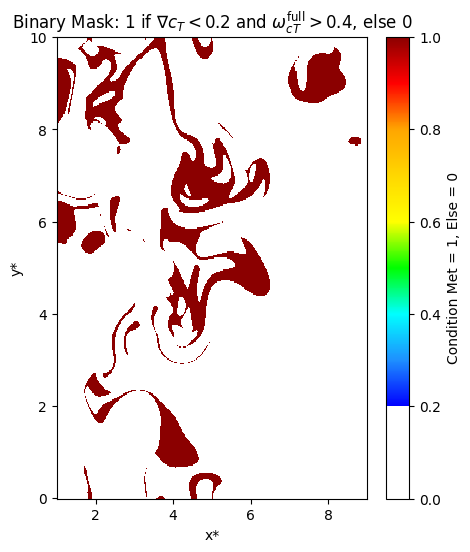

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you already have these 2D arrays: nabla_T, omega_cT_full, x_full, y_full

# 1. Create the binary array:
binary_array = ((grad_cT_star < 0.2) & (omega_cT_star > 0.4)).astype(float)

# 2. Plot it:
plt.figure(figsize=(5, 6))
plt.pcolor(
    x_trim,
    y_trim,
    np.moveaxis(binary_array, (0, 1), (1, 0)),  # Swap axes if needed
    cmap=cmap_custom,  # or any preferred colormap
    shading="auto",
    vmin=0.0,
    vmax=1.0
)
plt.colorbar(label="Condition Met = 1, Else = 0")

plt.title(r"Binary Mask: $1$ if $\nabla c_T < 0.2$ and $\omega_{cT}^{\text{full}} > 0.4$, else $0$")
plt.xlabel("x*")
plt.ylabel("y*")
plt.show()


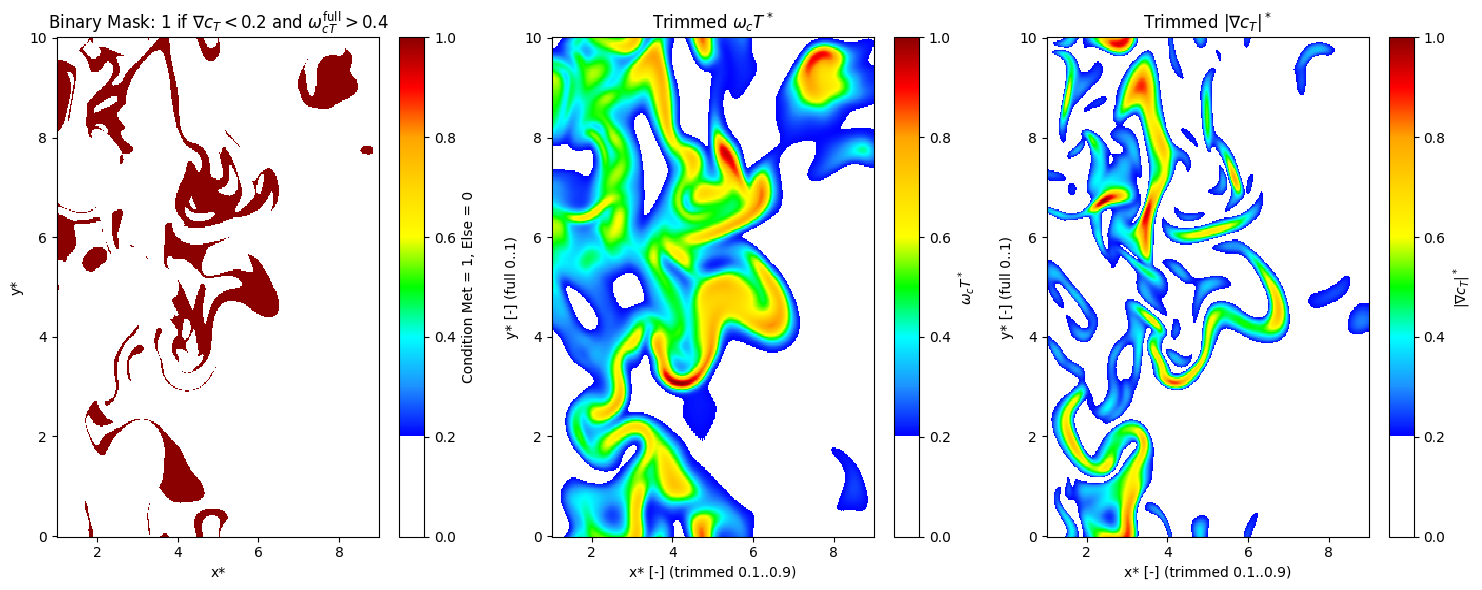

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define custom colormap
cmap_list = [
    (0.0, "white"),
    (0.2, "white"),
    (0.2, "blue"),
    (0.3, "dodgerblue"),
    (0.4, "cyan"),
    (0.5, "lime"),
    (0.6, "yellow"),
    (0.7, "gold"),
    (0.8, "orange"),
    (0.9, "red"),
    (1.0, "darkred"),
]
cmap_custom = mcolors.LinearSegmentedColormap.from_list("whiteToRed", cmap_list, N=512)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot 1: Binary Mask
im1 = axes[0].pcolor(x_trim, y_trim, np.moveaxis(binary_array, (0, 1), (1, 0)),
                     cmap=cmap_custom, shading="auto", vmin=0.0, vmax=1.0)
fig.colorbar(im1, ax=axes[0], label="Condition Met = 1, Else = 0")
axes[0].set_title(r"Binary Mask: $1$ if $\nabla c_T < 0.2$ and $\omega_{cT}^{\text{full}} > 0.4$")
axes[0].set_xlabel("x*")
axes[0].set_ylabel("y*")

# Plot 2: Trimmed ω_cT*
im2 = axes[1].pcolor(x_trim, y_trim, np.moveaxis(omega_cT_star, (0, 1), (1, 0)),
                     cmap=cmap_custom, shading="auto", vmin=0.0, vmax=1.0)
fig.colorbar(im2, ax=axes[1], label=r"$\omega_c T^*$")
axes[1].set_title(r"Trimmed $\omega_c T^*$")
axes[1].set_xlabel("x* [-] (trimmed 0.1..0.9)")
axes[1].set_ylabel("y* [-] (full 0..1)")

# Plot 3: Trimmed |∇cT|*
im3 = axes[2].pcolor(x_trim, y_trim, np.moveaxis(grad_cT_star, (0, 1), (1, 0)),
                     cmap=cmap_custom, shading="auto", vmin=0.0, vmax=1.0)
fig.colorbar(im3, ax=axes[2], label=r"$|\nabla c_T|^*$")
axes[2].set_title(r"Trimmed $|\nabla c_T|^*$")
axes[2].set_xlabel("x* [-] (trimmed 0.1..0.9)")
axes[2].set_ylabel("y* [-] (full 0..1)")

# Adjust layout
plt.tight_layout()
plt.show()
